In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [2]:
path_inception = f"{getcwd()}/../tmp2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (150,150, 3),
                               include_top = False,
                               weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
    
# model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [4]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc') is not None and logs.get('acc')>0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [5]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)                  # Flatten the output layer to 1 dimension

x = layers.Dense(1024, activation='relu')(x)       # Fully connected layer with 1,024 hidden units and ReLU activation

x = layers.Dropout(0.2)(x)                         # Dropout rate of 0.2 = 20%

x = layers.Dense  (1, activation='sigmoid')(x)     # Final sigmoid layer for classification      

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
# Get the Horse or Human dataset
path_horse_or_human = f"{getcwd()}/../tmp2/horse-or-human.zip"
# Get the Horse or Human Validation dataset
path_validation_horse_or_human = f"{getcwd()}/../tmp2/validation-horse-or-human.zip"
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import shutil

shutil.rmtree('/tmp')
local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [7]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses') # Directory with our training horse pictures
train_humans_dir = os.path.join(train_dir, 'humans') # Directory with our training humans pictures
validation_horses_dir = os.path.join(validation_dir, 'horses') # Directory with our validation horse pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')# Directory with our validation humanas pictures

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [8]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150)) 

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [9]:
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              epochs=3,
                              verbose = 1,
                              validation_data = validation_generator,
                              callbacks = [callbacks])

Epoch 1/3
52/52 [==============================] - 46s 884ms/step - loss: 0.2408 - acc: 0.8968 - val_loss: 0.0460 - val_acc: 0.9727
Epoch 2/3
51/52 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9752
Reached 97.0% accuracy so cancelling training!
52/52 [==============================] - 38s 735ms/step - loss: 0.0763 - acc: 0.9727 - val_loss: 7.0922e-04 - val_acc: 1.0000


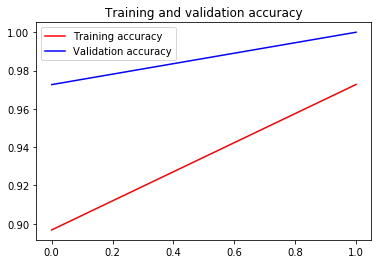

<Figure size 432x288 with 0 Axes>

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()